In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from base.Case import Case
import base.Train as Train

In /home/th/.config/matplotlib/stylelib/nu.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


In [3]:
case_filepath = 'cases/lorenz.case'
esn_type = 'normal'
case = Case.load(case_filepath, esn_type)

if esn_type == 'hybrid':
    case.esn.set_physics_numerics(case.ds.integrator, case.ds.dt, case.ds.norm, case.ds.system.convert_data_form)

N_valid = 500
N_used_in_training = case.N_skip + case.N_train + N_valid
N_not_used = len(case.ds.u) - (N_used_in_training+1)

ts_skip, ts_test = Train.split_timeseries(case.ds.u[-N_not_used:], split_lengths=[case.N_skip], overlap=[1], rest=True)

Xa_skip, _ = case.esn.open_loop(ts_skip, np.zeros(case.esn.xa_dim))
Yh_normal, _ = case.esn.closed_loop(len(ts_test), Xa_skip[-1], case.Wout)

In [5]:
case_filepath = 'cases/lorenz_hybrid.case'
esn_type = 'hybrid'
case = Case.load(case_filepath, esn_type)

if esn_type == 'hybrid':
    case.esn.set_physics_numerics(case.ds.integrator, case.ds.dt, case.ds.norm, case.ds.system.convert_data_form)

Xa_skip, _ = case.esn.open_loop(ts_skip, np.zeros(case.esn.xa_dim))
Yh_hybrid, _ = case.esn.closed_loop(len(ts_test), Xa_skip[-1], case.Wout)

2500
2501
2501


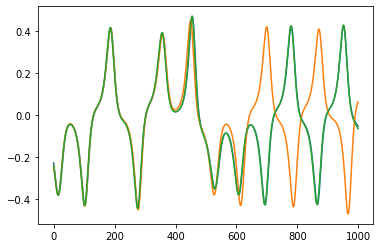

In [6]:
for ts in [ts_test, Yh_normal, Yh_hybrid]:
    print(len(ts))
    plt.plot(ts[:1000,0])

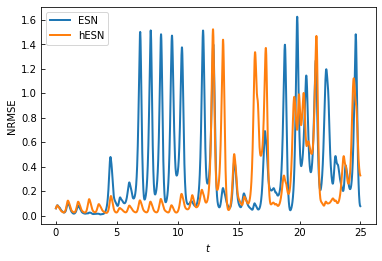

In [7]:
fig, ax = plt.subplots()

n = 5000
timeseries = [Yh_normal[1:], Yh_hybrid[1:]]
labels = ['ESN', 'hESN']
T = np.arange(ts_test.shape[0])*0.01

for ts, lbl in zip(timeseries, labels):
    ts = case.ds.denormalize(ts)
    delta = ts - case.ds.denormalize(ts_test)
    MSE = np.sqrt(np.sum(delta**2, axis=1))
    denominator = np.sqrt(np.mean(np.sum(ts**2, axis=1), axis=0))
    NRMSE = MSE/denominator
    plt.plot(T[:n], NRMSE[:n], label=lbl, lw=2)

ax.legend()
ax.set_xlabel('$t$')
ax.set_ylabel('NRMSE')
ax.tick_params(direction='in')

# plt.savefig('images/NRMSE.pdf')

## 2D joint PDF

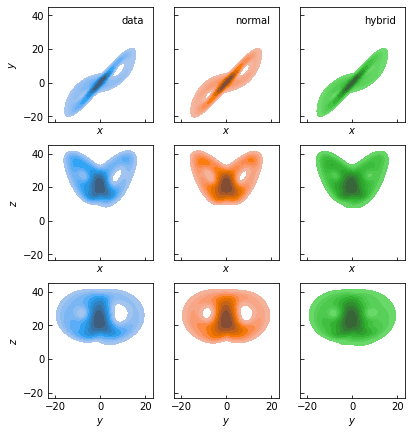

In [8]:
import seaborn as sns
sns.reset_orig()

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
nrows = 3
ncols = 3

fig = plt.figure(figsize=(6.4,4.8*1.5))

ax1 = fig.add_subplot(nrows, ncols, 1)
axs = np.array([ax1] + [fig.add_subplot(nrows, ncols, i, sharex=ax1, sharey=ax1) \
                            for i in range(2, nrows*ncols+1)]).reshape((nrows, ncols))

if axs.ndim == 1:
    axs = axs.reshape(nrows, ncols)

fill = True

variables = 'xyz'
pairs = [(0,1), (0,2), (1,2)]
cols = ['data', 'normal', 'hybrid']

for i in range(nrows):
    for j, ts in enumerate([ts_test, Yh_normal, Yh_hybrid]):
        ax = axs[i,j]
        ts = case.ds.denormalize(ts)
        a,b = pairs[i]
        sns.kdeplot(x=ts[:,a],
                    y=ts[:,b],
                    fill=fill,
                    color=colors[j],
                    ax=ax,
                    cut=1,
                    label=cols[j])
        
        if j == 0:
            ax.set_ylabel('${}$'.format(variables[b]))
        else:
            plt.setp(ax.get_yticklabels(), visible=False)
        
        if i == nrows-1:
            pass
        else:
            plt.setp(ax.get_xticklabels(), visible=False)
        
        if i == 0:
            ax.legend(frameon=False)
        
        ax.set_xlabel('${}$'.format(variables[a]))
        ax.tick_params(which='both', direction='in')
    
# plt.savefig('images/joint_distribution.pdf')